In [1]:
### Load and preprocess w/ 50k/10k/10k train/val/test split ###

from collections import Counter
import keras_tuner as kt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Load dataset
(X_train_val_unscaled, y_train_val), (X_test_unscaled, y_test) = tf.keras.datasets.mnist.load_data()

# Scale pixel values to b/w 0 and 1
X_train_val = (X_train_val_unscaled / 255).astype(np.float32)
X_test = (X_test_unscaled / 255).astype(np.float32)

# Shuffle + stratified split the 60k X_train_val into 50k/10k X_train/X_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Add 1 channel to the input arrays (CNNs require an axis for number of channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Print info on the preprocessed data
print(f'Train: num_samples={len(X_train)} | priors={dict(sorted(Counter(y_train).items()))}')
print(f'Val: num_samples={len(X_val)} | priors={dict(sorted(Counter(y_val).items()))}')
print(f'Test: num_samples={len(X_test)} | priors={dict(sorted(Counter(y_test).items()))}')

Train: num_samples=48000 | priors={0: 4738, 1: 5394, 2: 4766, 3: 4905, 4: 4674, 5: 4337, 6: 4734, 7: 5012, 8: 4681, 9: 4759}
Val: num_samples=12000 | priors={0: 1185, 1: 1348, 2: 1192, 3: 1226, 4: 1168, 5: 1084, 6: 1184, 7: 1253, 8: 1170, 9: 1190}
Test: num_samples=10000 | priors={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [ ]:
### Create and run Bayesian Optimization ###

def build_model(hp):
    """Model building function."""

    # Define static hyperparameters for general architecture (established from previous HPT in notebook 2b)
    num_conv_layers = 3
    num_filters_first_layer = 16
    num_filters_sub_layers = 32
    kernel_size = 5
    subsample_type = '5x5stride2'

    dense_layer_size = 256
    activation = 'relu'

    # Define dynamic hyperparameters that will be re-tuned for the introduction of data augmentation
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.0005, 0.001, 0.005, 0.01], default=0.001)

    # Add new hyperparameters to tune for data augmentation
    rotation_range = hp.Float('rotation_range', min_value=0.0, max_value=0.3, step=0.05, default=0.1)
    zoom_range = hp.Float('zoom_range', min_value=0.0, max_value=0.1, step=0.025, default=0.05)
    width_shift_range = hp.Float('width_shift_range', min_value=0.0, max_value=0.2, step=0.05, default=0.1)
    height_shift_range = hp.Float('height_shift_range', min_value=0.0, max_value=0.2, step=0.05, default=0.1)

    # Build the model
    input_size = (28, 28, 1)
    output_size = 10

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_size))

    # Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
    model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
    model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range))
    model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

    for i in range(num_conv_layers):

        if i == 0:
            num_filters = num_filters_first_layer
        else:
            num_filters = num_filters_sub_layers
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=kernel_size,
                activation=activation,
                padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())

        if subsample_type == '2x2pool':
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        else: # '5x5stride2'
            model.add(
                tf.keras.layers.Conv2D(
                    num_filters,
                    kernel_size=5,
                    activation=activation,
                    padding='same',
                    strides=2
                )
            )
        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    model.add(tf.keras.layers.Flatten())
    model.add(
        tf.keras.layers.Dense(
            dense_layer_size,
            activation=activation,
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


MAX_TRIALS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    directory='tuning_results',
    project_name='cnn_data_aug_bayesian'
)

tuner.search(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

In [3]:
### Get best model from Bayesian and train it fully ###

# Get the best model after the tuning process
model_num = 1
best_model = tuner.get_best_models(num_models=model_num)[model_num - 1]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=model_num)[model_num - 1]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Compile the model with the best hps
best_learn_rate = best_hyperparameters.values['learning_rate']
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_learn_rate), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

# Train the best model
history = best_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Best Hyperparameters:  {'dropout_rate': 0.2, 'learning_rate': 0.01, 'rotation_range': 0.05, 'zoom_range': 0.0, 'width_shift_range': 0.15000000000000002, 'height_shift_range': 0.1}
Epoch 1/500


c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


188/188 - 22s - 115ms/step - accuracy: 0.9514 - loss: 0.1561 - val_accuracy: 0.9528 - val_loss: 0.2440
Epoch 2/500
188/188 - 16s - 87ms/step - accuracy: 0.9719 - loss: 0.0953 - val_accuracy: 0.9607 - val_loss: 0.1479
Epoch 3/500
188/188 - 16s - 84ms/step - accuracy: 0.9780 - loss: 0.0708 - val_accuracy: 0.9841 - val_loss: 0.0581
Epoch 4/500
188/188 - 15s - 80ms/step - accuracy: 0.9801 - loss: 0.0678 - val_accuracy: 0.9768 - val_loss: 0.0887
Epoch 5/500
188/188 - 15s - 77ms/step - accuracy: 0.9820 - loss: 0.0592 - val_accuracy: 0.9880 - val_loss: 0.0472
Epoch 6/500
188/188 - 15s - 77ms/step - accuracy: 0.9831 - loss: 0.0538 - val_accuracy: 0.9884 - val_loss: 0.0398
Epoch 7/500
188/188 - 15s - 78ms/step - accuracy: 0.9856 - loss: 0.0488 - val_accuracy: 0.9891 - val_loss: 0.0415
Epoch 8/500
188/188 - 14s - 76ms/step - accuracy: 0.9857 - loss: 0.0483 - val_accuracy: 0.9922 - val_loss: 0.0301
Epoch 9/500
188/188 - 14s - 75ms/step - accuracy: 0.9871 - loss: 0.0431 - val_accuracy: 0.9919 - va

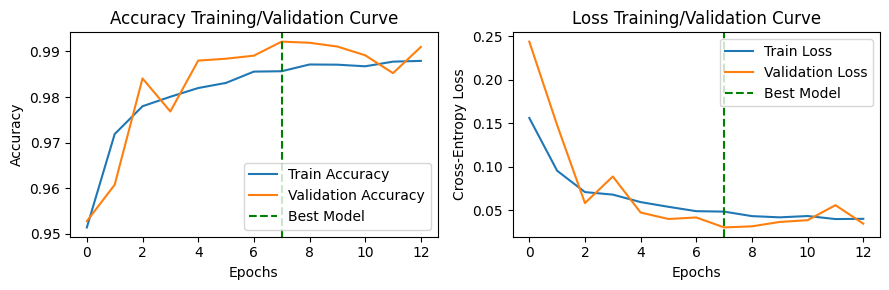

Final Results after 7 epochs:
Accuracy: Train=98.57% | Val=99.22%
Loss: Train=0.0483 | Val=0.0301


In [4]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Add vertical trace for best model
restore_weights_idx = -early_stopping.patience - 1
best_epoch = len(history.history['accuracy']) + restore_weights_idx
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')

# Show plots
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

print(f'Final Results after {best_epoch} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][restore_weights_idx] * 100:.2f}% | Val={history.history['val_accuracy'][restore_weights_idx] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][restore_weights_idx]:.4f} | Val={history.history['val_loss'][restore_weights_idx]:.4f}')

In [ ]:
### Save the model ###
 
best_model.save('models/cnn_data_aug_hpt.keras')

In [1]:
### Clean tuning_results folder by purging checkpoint models ###
 
import os

# Loop through all trial subfolders and delete .h5 checkpoint model files
results_dir = 'tuning_results/cnn_data_aug_bayesian'
for trial_folder in os.listdir(results_dir):
    trial_path = os.path.join(results_dir, trial_folder)
    if os.path.isdir(trial_path):
        for file in os.listdir(trial_path):
            if 'checkpoint' in file or file.endswith('.h5'):
                file_path = os.path.join(trial_path, file)
                os.remove(file_path)